In [2]:
import pandas as pd
import numpy as np
import joblib
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
from sklearn.svm import SVC 
from sklearn.neural_network import  MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns 
import matplotlib.pyplot as plt 
import os 
from pathlib import Path 

In [3]:
pd.set_option("display.max_columns", None)
mens_df = pd.read_csv('../data/modeling/mens_reg_season_ml.csv')

womens_df = pd.read_csv('../data/modeling/womens_reg_season_ml.csv')
womens_df = df_filtered = womens_df[~((womens_df['Season'] == 2010) & ((womens_df['Team1'] == 3445) | (womens_df['Team2'] == 3445)))]


# Logistic Regression 

In [4]:
mens_x = mens_df.drop(columns=['Season', 'DayNum', 'Team1', 'Team2', 'Team1_Wins', 'ConfAbbrev_1', 'ConfAbbrev_2'])
                     #'Threes_Per_Game_1', 'Threes_Per_Game_2', 'Free_Throws_Per_Game_1', 'Free_Throws_Per_Game_2', 
                     #'Win_pct_last_10_games_1', 'Win_pct_last_10_games_2', 'Opp_Three_Point_Percentage_1', 'Opp_Three_Point_Percentage_2',
                     #'Turnovers_Per_Game_1', 'Turnovers_Per_Game_2', 'Opp_Turnovers_Per_Game_1', 'Opp_Turnovers_Per_Game_2' 
                     #]) 
                     #'Pace_1', 'Pace_2', 'SOS_1', 'SOS_2', 'SRS_1', 'SRS_2'

mens_y = mens_df['Team1_Wins']

womens_x = womens_df.drop(columns=['Season', 'DayNum', 'Team1', 'Team2', 'Team1_Wins', 
                     'Win_pct_last_10_games_1', 'Win_pct_last_10_games_2']) 

womens_y = womens_df['Team1_Wins']

# Train the model 
X_train, X_test, y_train, y_test = train_test_split(mens_x, mens_y, test_size=0.2, random_state=50)

# Normalize the data 
scaler = StandardScaler()

# Fit on training data and transform both train & test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Logistic Regression model
logreg = LogisticRegression(C=100)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=100)

### Feature Engineering

**Analyze which features are the most important**

In [5]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': logreg.coef_[0]
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=True)
feature_importance

,Feature,Importance
42,SRS_2,-1.005204
25,Win_Percentage_2,-0.940687
43,SOS_2,-0.480894
35,Opp_FG_Percentage_2,-0.224766
1,Points_Per_Game_1,-0.130049
2,FG_Percentage_1,-0.126635
21,3PAr_1,-0.108858
8,Defensive_Rebound_Rate_1,-0.090408
5,Free_Throws_Per_Game_1,-0.084124
39,Opp_Threes_Per_Game_2,-0.082455


**Identify which features are highly correlated and can be removed**

In [197]:
corr_matrix = X_train.corr().abs() 
# Select upper triangle of correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation > 0.9
high_correlation = [(column, index) for column in upper.columns for index in upper.index if upper[column][index] > 0.7]

# Print correlated feature pairs
for f1, f2 in high_correlation:
    print(f"High correlation: {f1} <--> {f2} (r = {corr_matrix.loc[f1, f2]:.2f})")

High correlation: FG_Percentage_1 <--> Points_Per_Game_1 (r = 0.84)
High correlation: Three_Point_Percentage_1 <--> Points_Per_Game_1 (r = 0.70)
High correlation: Three_Point_Percentage_1 <--> FG_Percentage_1 (r = 0.78)
High correlation: Defensive_Rebound_Rate_1 <--> FG_Percentage_1 (r = 0.72)
High correlation: Opp_Three_Point_Percentage_1 <--> Opp_FG_Percentage_1 (r = 0.76)
High correlation: FG_Percentage_2 <--> Points_Per_Game_2 (r = 0.84)
High correlation: Three_Point_Percentage_2 <--> Points_Per_Game_2 (r = 0.70)
High correlation: Three_Point_Percentage_2 <--> FG_Percentage_2 (r = 0.79)
High correlation: Defensive_Rebound_Rate_2 <--> FG_Percentage_2 (r = 0.72)
High correlation: Opp_Three_Point_Percentage_2 <--> Opp_FG_Percentage_2 (r = 0.76)


### Model Evaluation

Brier Score: 0.1580
Accuracy: 0.7660
Log Loss: 0.4785
ROC-AUC Score: 0.8500


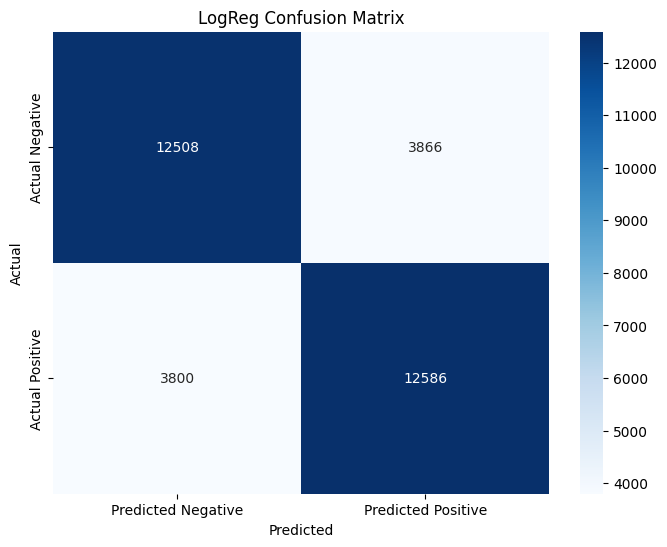

In [198]:
# Make predictions on the test set
y_pred = logreg.predict(X_test_scaled)
y_pred_probs = logreg.predict_proba(X_test_scaled)[:, 1]

brier = brier_score_loss(y_test, y_pred_probs)
print(f'Brier Score: {brier:.4f}')

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

logloss = log_loss(y_test, y_pred_probs)
print(f'Log Loss: {logloss:.4f}')

auc = roc_auc_score(y_test, y_pred_probs)
print(f'ROC-AUC Score: {auc:.4f}')

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LogReg Confusion Matrix')
plt.show()

## K-Nearest Neighbors (k-NN)

k-NN Brier Score: 0.1822
k-NN Accuracy: 0.7230
k-NN Log Loss: 0.5482
k-NN ROC-AUC Score: 0.8009


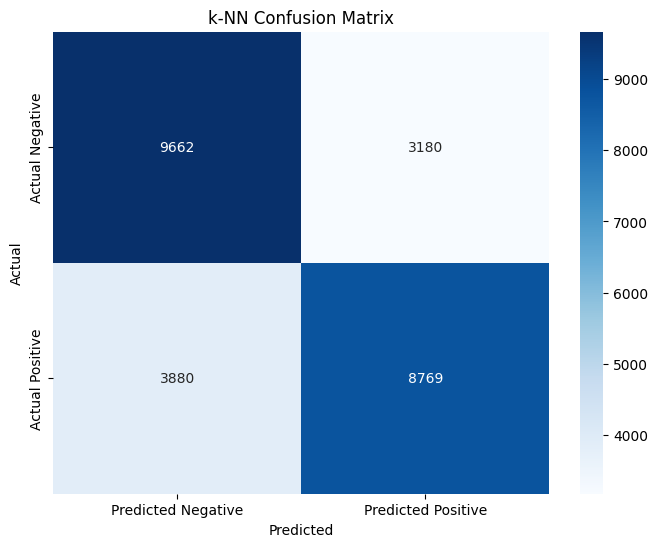

In [86]:
# k-NN model
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test_scaled)
y_pred_probs_knn = knn.predict_proba(X_test_scaled)[:, 1]

# Calculate evaluation metrics
knn_brier = brier_score_loss(y_test, y_pred_probs_knn)
print(f'k-NN Brier Score: {knn_brier:.4f}')

knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f'k-NN Accuracy: {knn_accuracy:.4f}')

knn_logloss = log_loss(y_test, y_pred_probs_knn)
print(f'k-NN Log Loss: {knn_logloss:.4f}')

knn_auc = roc_auc_score(y_test, y_pred_probs_knn)
print(f'k-NN ROC-AUC Score: {knn_auc:.4f}')

# Calculate and display the confusion matrix
knn_conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('k-NN Confusion Matrix')
plt.show()

## Decision Trees: Boosting - Random Forest 

Random Forest Brier Score: 0.2171
Random Forest Accuracy: 0.6853
Random Forest Log Loss: 0.6638
Random Forest ROC-AUC Score: 0.7521


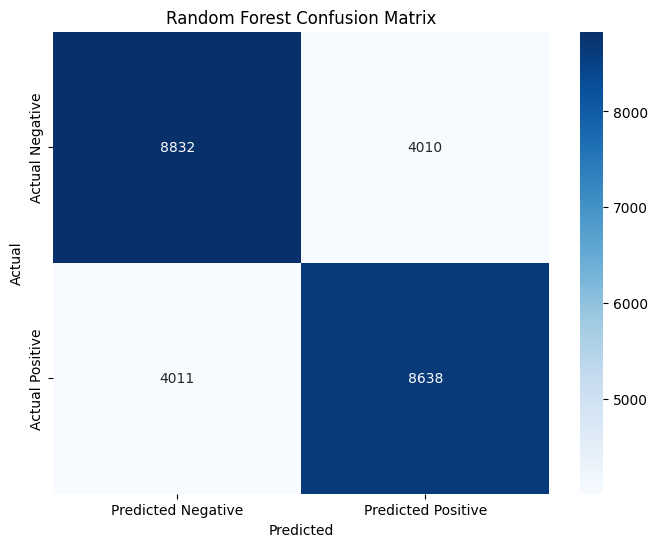

In [87]:
# Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test)
y_pred_probs_rf = rf.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
rf_brier = brier_score_loss(y_test, y_pred_probs_rf)
print(f'Random Forest Brier Score: {rf_brier:.4f}')

rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

rf_logloss = log_loss(y_test, y_pred_probs_rf)
print(f'Random Forest Log Loss: {rf_logloss:.4f}')

rf_auc = roc_auc_score(y_test, y_pred_probs_rf)
print(f'Random Forest ROC-AUC Score: {rf_auc:.4f}')

# Calculate and display the confusion matrix
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


## Decision Trees: Bagging - Extreme Gradient Boosting

In [7]:
# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 10),
    'min_child_weight': np.arange(1, 10),
    'subsample': np.linspace(0.5, 1.0, 5),
    'colsample_bytree': np.linspace(0.5, 1.0, 5)
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

# Set up Randomized Search with Brier Score
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of different parameter combinations to try
    scoring='neg_brier_score',  # Minimizing Brier Score
    cv=3,  # 3-fold cross-validation
    verbose=0,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Best Brier Score (negated back to positive)
best_brier_score = -random_search.best_score_
print("Best Brier Score:", best_brier_score)

Traceback (most recent call last):
  File "/Users/alexreid/Desktop/Projects/March_ML_Mania_2025/venv/lib/python3.13/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
    ~~~~~~~~~~~~~~~^^^^^^
KeyError: '/var/folders/mm/p9j4d6_x5b93fg7gz7zjjdkm0000gn/T/joblib_memmapping_folder_45533_3483bb6938874082a9be7d821f699a36_3f918e8ed38944f690e64938e7089d10/45533-4896813232-c5fc1949c2ed4d778789e21dba5519bb.pkl'
Traceback (most recent call last):
  File "/Users/alexreid/Desktop/Projects/March_ML_Mania_2025/venv/lib/python3.13/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
    ~~~~~~~~~~~~~~~^^^^^^
KeyError: '/var/folders/mm/p9j4d6_x5b93fg7gz7zjjdkm0000gn/T/joblib_memmapping_folder_45533_3483bb6938874082a9be7d821f699a36_3f918e8ed38944f690e64938e7089d10/45533-4896813232-c5fc1949c2ed4d778789e21dba5519bb.pkl'
Traceback (most recent call last):
  File "/Users/alexreid/Des

KeyboardInterrupt: 

XGBoost Brier Score: 0.1643
XGBoost Accuracy: 0.7532
XGBoost Log Loss: 0.4930
XGBoost ROC-AUC Score: 0.8381


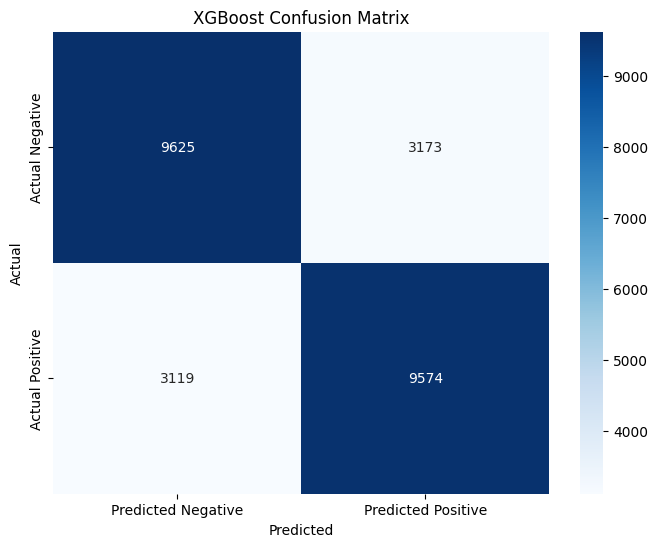

In [246]:
# Train the tuned XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic", eval_metric="logloss",
    subsample=0.5, n_estimators=500, min_child_weight=1, max_depth=7,
    learning_rate=0.01, colsample_bytree=0.75
)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
xgb_brier = brier_score_loss(y_test, y_pred_probs_xgb)
print(f'XGBoost Brier Score: {xgb_brier:.4f}')

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')

xgb_logloss = log_loss(y_test, y_pred_probs_xgb)
print(f'XGBoost Log Loss: {xgb_logloss:.4f}')

xgb_auc = roc_auc_score(y_test, y_pred_probs_xgb)
print(f'XGBoost ROC-AUC Score: {xgb_auc:.4f}')

# Calculate and display the confusion matrix
xgb_conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

## Neural Network

In [129]:
# Train the Neural Network Model 
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # Two hidden layers with 128 and 64 neurons
    activation='relu',             # Use ReLU activation for non-linearity
    solver='adam',                 # Adam optimizer
    alpha=0.01,                    # L2 regularization (to prevent overfitting)
    max_iter=1000,                  # Number of training iterations
    random_state=57
)

mlp.fit(X_train_scaled, y_train)

# Get predicted probabilities
y_pred_proba = mlp.predict_proba(X_test_scaled)[:, 1]

# Calculate Brier Score (since lower is better)
brier_score = brier_score_loss(y_test, y_pred_proba)
print("Brier Score (Neural Network):", brier_score)



Brier Score (Neural Network): 0.178484156943791


# Final Predictions 

## Mens

In [247]:
# Use the regular season model to create predictions on the post season 
m_final_ml = pd.read_csv('../data/modeling/mens_tourney_ml.csv')

original_features = X_train.columns 
post_season = m_final_ml[original_features]

postseason_predictions = xgb_model.predict_proba(post_season)[:, 1]
m_final_ml['reg_season_pred'] = postseason_predictions
m_final_ml.head(5) 

,Season,DayNum,Team1,Team2,Team1_Wins,Win_Percentage_1,Points_Per_Game_1,FG_Percentage_1,Threes_Per_Game_1,Three_Point_Percentage_1,Free_Throws_Per_Game_1,Free_Throw_Percentage_1,Offensive_Rebound_Rate_1,Defensive_Rebound_Rate_1,Turnovers_Per_Game_1,Opp_FG_Percentage_1,Opp_Three_Point_Percentage_1,Opp_Free_Throws_Per_Game_1,Opp_Turnovers_Per_Game_1,Opp_Threes_Per_Game_1,Turnover_Margin_1,ConfAbbrev_1,Win_pct_last_10_games_1,SRS_1,SOS_1,Pace_1,FTr_1,3PAr_1,offensiveRating_1,defensiveRating_1,avg_height_1,Win_Percentage_2,Points_Per_Game_2,FG_Percentage_2,Threes_Per_Game_2,Three_Point_Percentage_2,Free_Throws_Per_Game_2,Free_Throw_Percentage_2,Offensive_Rebound_Rate_2,Defensive_Rebound_Rate_2,Turnovers_Per_Game_2,Opp_FG_Percentage_2,Opp_Three_Point_Percentage_2,Opp_Free_Throws_Per_Game_2,Opp_Turnovers_Per_Game_2,Opp_Threes_Per_Game_2,Turnover_Margin_2,ConfAbbrev_2,Win_pct_last_10_games_2,SRS_2,SOS_2,Pace_2,FTr_2,3PAr_2,offensiveRating_2,defensiveRating_2,avg_height_2,Seed_1,Seed_2,reg_season_pred
0,2014,134,1107,1291,1,0.562500,66.031250,43.914373,13.468750,36.426914,21.718750,74.820144,32.387476,70.905764,12.625000,41.863140,35.247209,15.843750,11.968750,19.593750,-0.656250,aec,0.7,-3.31,-5.22,63.1,0.420,0.261,110.7,110.2,77.29,0.500000,76.250000,44.068706,24.906250,35.633626,21.687500,74.063401,28.345070,66.855524,12.000000,49.312896,33.626374,20.312500,13.281250,14.218750,1.281250,nec,0.6,-6.32,-4.44,70.0,0.367,0.434,112.5,112.6,76.00,16,16,0.592202
1,2014,134,1301,1462,1,0.617647,70.794118,45.865434,14.764706,30.278884,20.852941,66.149506,34.790060,63.735343,10.411765,42.438765,31.951641,23.794118,11.529412,17.029412,1.117647,acc,0.5,9.02,7.44,64.9,0.370,0.255,111.1,110.9,77.60,0.636364,72.212121,47.130919,14.727273,35.390947,22.848485,68.832891,34.105653,71.216098,12.363636,42.714127,35.394127,21.696970,11.272727,19.606061,-1.090909,big_east,0.5,11.84,8.14,65.7,0.416,0.270,111.6,110.9,77.12,12,12,0.438761
2,2014,135,1142,1411,1,0.366667,62.000000,40.371517,18.900000,33.509700,17.766667,68.667917,30.842912,66.953714,8.966667,43.837442,33.978495,21.466667,10.833333,15.500000,1.866667,big_west,0.5,-1.34,1.69,60.8,0.326,0.354,110.2,110.9,75.76,0.562500,75.062500,45.821326,17.593750,35.879218,26.812500,71.095571,33.456905,68.924640,13.218750,44.632768,35.528596,17.906250,10.843750,18.031250,-2.375000,swac,0.9,-8.41,-10.07,68.2,0.491,0.325,111.9,112.3,76.50,16,16,0.732105
3,2014,135,1397,1234,1,0.625000,70.500000,44.249292,16.875000,32.962963,22.781250,70.781893,39.692586,72.423146,10.875000,41.238318,34.047109,17.687500,10.843750,14.593750,-0.031250,sec,0.6,17.34,7.84,62.8,0.416,0.308,112.2,109.1,77.60,0.625000,82.000000,46.469367,16.562500,35.283019,27.593750,73.272933,38.107639,71.063479,11.375000,41.401274,31.954351,20.500000,13.468750,21.906250,2.093750,big_ten,0.3,18.58,7.43,69.8,0.453,0.275,113.3,110.1,78.73,11,11,0.525058
4,2014,136,1163,1386,1,0.764706,71.852941,44.835046,18.382353,38.720000,21.000000,76.050420,31.238616,66.563467,11.676471,38.733126,32.894737,20.088235,12.911765,17.882353,1.235294,aac,0.7,17.23,8.63,65.5,0.383,0.343,111.4,107.7,77.35,0.727273,71.272727,46.858790,19.363636,38.028169,22.818182,64.143426,29.488372,72.393661,12.333333,41.842105,33.742331,17.636364,10.151515,19.757576,-2.181818,a_ten,0.8,9.05,5.08,66.0,0.436,0.369,111.4,110.2,77.62,7,10,0.715595


In [248]:
# Use Regular Season Model to predict 2025 post season matchups 
mens_season_25_data = pd.read_csv("../data/modeling/mens_25_season_ml.csv")

mens_25_seeds = pd.read_csv("../data/MNCAATourneySeeds.csv")
mens_25_seeds['Seed'] = mens_25_seeds['Seed'].str[1:].str.rstrip('ab')

active_m_teams = mens_25_seeds[mens_25_seeds['Season'] == 2025]


print(f"Active men's teams: {len(active_m_teams)}")

matchups_list = [] 

# Ensure matchups are only between active teams
for team1, team2 in combinations(active_m_teams['TeamID'], 2):
    lower_id = min(team1, team2)
    higher_id = max(team1, team2)
    seed1 = active_m_teams.loc[active_m_teams['TeamID'] == lower_id, 'Seed'].values[0]
    seed2 = active_m_teams.loc[active_m_teams['TeamID'] == higher_id, 'Seed'].values[0]
    matchups_list.append(
        {
            'Team1': lower_id, 
            'Team2': higher_id,
            'Seed_1': seed1, 
            'Seed_2': seed2 
        }
    )

m_matchups = pd.DataFrame(matchups_list)


# Merge games dataset with teams stats 
m_tourney_2025 = m_matchups.merge(mens_season_25_data, left_on=['Team1'], right_on=['TeamID'], how='left')
m_tourney_2025 = m_tourney_2025.rename(columns={col: col + "_1" for col in mens_season_25_data.columns if col not in ["Season", "TeamID"]})

m_tourney_2025 = m_tourney_2025.merge(mens_season_25_data, left_on=['Team2'], right_on=['TeamID'], how='left')
m_tourney_2025 = m_tourney_2025.rename(columns={col: col + "_2" for col in mens_season_25_data.columns if col not in ["Season", "TeamID"]})
m_tourney_2025.drop(columns=['TeamID_x','TeamID_y', 'Season_x', 'Season_y'], inplace=True)

# Use the regular season model to create predictions on the post season 

original_features = X_train.columns 
postseason_25 = m_tourney_2025[original_features]

postseason_25_predictions = xgb_model.predict_proba(postseason_25)[:, 1]
m_tourney_2025['reg_season_pred'] = postseason_25_predictions
m_tourney_2025['reg_season_pred'] = m_tourney_2025['reg_season_pred'].round(3)

m_tourney_2025

Active men's teams: 68


,Team1,Team2,Seed_1,Seed_2,TeamName_1,Win_Percentage_1,Points_Per_Game_1,FG_Percentage_1,Threes_Per_Game_1,Three_Point_Percentage_1,Free_Throws_Per_Game_1,Free_Throw_Percentage_1,Offensive_Rebound_Rate_1,Defensive_Rebound_Rate_1,Turnovers_Per_Game_1,Opp_FG_Percentage_1,Opp_Three_Point_Percentage_1,Opp_Free_Throws_Per_Game_1,Opp_Turnovers_Per_Game_1,Opp_Threes_Per_Game_1,Turnover_Margin_1,ConfAbbrev_1,Win_pct_last_10_games_1,SRS_1,SOS_1,Pace_1,FTr_1,3PAr_1,offensiveRating_1,defensiveRating_1,avg_height_1,TeamName_2,Win_Percentage_2,Points_Per_Game_2,FG_Percentage_2,Threes_Per_Game_2,Three_Point_Percentage_2,Free_Throws_Per_Game_2,Free_Throw_Percentage_2,Offensive_Rebound_Rate_2,Defensive_Rebound_Rate_2,Turnovers_Per_Game_2,Opp_FG_Percentage_2,Opp_Three_Point_Percentage_2,Opp_Free_Throws_Per_Game_2,Opp_Turnovers_Per_Game_2,Opp_Threes_Per_Game_2,Turnover_Margin_2,ConfAbbrev_2,Win_pct_last_10_games_2,SRS_2,SOS_2,Pace_2,FTr_2,3PAr_2,offensiveRating_2,defensiveRating_2,avg_height_2,reg_season_pred
0,1104,1181,02,01,Alabama,0.757576,91.121212,48.259643,29.787879,34.994914,25.848485,71.629543,32.700994,73.296789,12.121212,42.456609,30.798479,23.060606,10.060606,23.909091,-2.060606,sec,0.5,25.97,16.27,76.2,0.401,0.462,126.2,96.8,78.36,Duke,0.911765,82.705882,48.805970,26.823529,37.719298,18.970588,78.449612,34.072581,77.030568,9.205882,38.645621,30.872483,14.676471,10.764706,21.911765,1.558824,acc,1.0,30.32,9.52,66.6,0.321,0.454,128.8,90.1,79.20,0.342
1,1181,1458,01,03,Duke,0.911765,82.705882,48.805970,26.823529,37.719298,18.970588,78.449612,34.072581,77.030568,9.205882,38.645621,30.872483,14.676471,10.764706,21.911765,1.558824,acc,1.0,30.32,9.52,66.6,0.321,0.454,128.8,90.1,79.20,Wisconsin,0.742857,79.714286,45.181598,28.400000,34.909457,19.914286,82.783357,24.836601,75.125628,9.314286,41.431262,33.012048,17.028571,9.685714,23.714286,0.371429,big_ten,0.6,21.15,11.41,68.7,0.340,0.478,121.9,98.2,77.71,0.685
2,1112,1181,04,01,Arizona,0.647059,81.735294,47.266570,21.058824,32.402235,22.235294,78.439153,34.559535,74.319728,11.264706,41.522989,33.600000,17.911765,11.088235,25.735294,-0.176471,big_twelve,0.5,23.14,13.84,70.2,0.366,0.346,122.8,96.7,78.00,Duke,0.911765,82.705882,48.805970,26.823529,37.719298,18.970588,78.449612,34.072581,77.030568,9.205882,38.645621,30.872483,14.676471,10.764706,21.911765,1.558824,acc,1.0,30.32,9.52,66.6,0.321,0.454,128.8,90.1,79.20,0.212
3,1181,1332,01,05,Duke,0.911765,82.705882,48.805970,26.823529,37.719298,18.970588,78.449612,34.072581,77.030568,9.205882,38.645621,30.872483,14.676471,10.764706,21.911765,1.558824,acc,1.0,30.32,9.52,66.6,0.321,0.454,128.8,90.1,79.20,Oregon,0.727273,76.212121,45.684755,22.636364,34.002677,19.575758,76.315789,27.579162,71.854613,10.515152,43.138244,31.713900,16.636364,11.575758,22.454545,1.060606,big_ten,0.8,17.50,12.23,68.6,0.334,0.386,116.4,97.1,77.28,0.751
4,1140,1181,06,01,BYU,0.727273,80.969697,48.223350,28.848485,37.079832,18.000000,70.538721,31.606218,76.267943,11.454545,42.879499,34.782609,17.121212,11.363636,25.787879,-0.090909,big_twelve,0.9,19.82,9.72,67.8,0.302,0.483,121.6,100.4,78.35,Duke,0.911765,82.705882,48.805970,26.823529,37.719298,18.970588,78.449612,34.072581,77.030568,9.205882,38.645621,30.872483,14.676471,10.764706,21.911765,1.558824,acc,1.0,30.32,9.52,66.6,0.321,0.454,128.8,90.1,79.20,0.241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,1213,1303,13,15,Grand Canyon,0.781250,78.500000,45.922747,19.562500,31.629393,25.593750,73.504274,30.715005,73.724008,12.625000,41.486558,32.055215,19.062500,14.406250,20.375000,1.781250,wac,0.9,5.82,-3.02,72.7,0.442,0.339,109.0,101.5,78.50,NE Omaha,0.625000,77.750000,46.401719,22.468750,36.717663,21.156250,73.264402,27.783453,78.118609,10.437500,45.285088,35.098522,21.468750,9.781250,25.375000,-0.656250,summit,0.8,-1.07,-2.85,69

In [249]:
# 2025 Tourney Prediction Data 
output_dir = Path("..") / "data" / "modeling"
output_dir.mkdir(parents=True, exist_ok =True)
m_25_final_output_path = output_dir / "mens_25_final_ml.csv"
m_tourney_2025.to_csv(m_25_final_output_path, index=False)

In [250]:
# 2025 Post Season Training Data 
output_dir = Path("..") / "data" / "modeling"
output_dir.mkdir(parents=True, exist_ok =True)
m_final_output_path = output_dir / "mens_final_ml.csv"
m_final_ml.to_csv(m_final_output_path, index=False)

## Womens

In [ ]:
# Use the regular season model to create predictions on the post season 
w_final_ml = pd.read_csv('../data/modeling/womens_tourney_ml.csv')

original_features = X_train.columns 
post_season = w_final_ml[original_features]

postseason_predictions = xgb_model.predict_proba(post_season)[:, 1]
w_final_ml['reg_season_pred'] = postseason_predictions
w_final_ml.head(5) 

,Season,DayNum,Team1,Team2,Team1_Wins,Win_Percentage_1,Points_Per_Game_1,FG_Percentage_1,Threes_Per_Game_1,Three_Point_Percentage_1,Free_Throws_Per_Game_1,Free_Throw_Percentage_1,Offensive_Rebound_Rate_1,Defensive_Rebound_Rate_1,Turnovers_Per_Game_1,Opp_FG_Percentage_1,Opp_Three_Point_Percentage_1,Opp_Free_Throws_Per_Game_1,Opp_Turnovers_Per_Game_1,Win_pct_last_10_games_1,Win_Percentage_2,Points_Per_Game_2,FG_Percentage_2,Threes_Per_Game_2,Three_Point_Percentage_2,Free_Throws_Per_Game_2,Free_Throw_Percentage_2,Offensive_Rebound_Rate_2,Defensive_Rebound_Rate_2,Turnovers_Per_Game_2,Opp_FG_Percentage_2,Opp_Three_Point_Percentage_2,Opp_Free_Throws_Per_Game_2,Opp_Turnovers_Per_Game_2,Win_pct_last_10_games_2,Seed_1,Seed_2,reg_season_pred
0,2010,138,3124,3201,1,0.718750,72.093750,46.311703,8.656250,28.519856,24.000000,72.656250,35.878565,71.000000,16.875000,33.732535,27.742947,13.187500,15.718750,0.6,0.818182,73.454545,41.978346,24.848485,35.487805,18.242424,70.930233,35.865309,66.748971,15.636364,40.459647,29.978118,16.303030,19.878788,0.9,4,13,0.478150
1,2010,138,3173,3395,1,0.807692,70.769231,42.062500,17.461538,31.277533,19.346154,69.980119,38.261738,69.923372,16.961538,36.762779,32.191781,16.576923,18.346154,0.8,0.733333,72.300000,41.488223,19.200000,35.763889,18.400000,74.818841,34.763948,63.472563,16.033333,36.571748,28.429752,16.300000,20.666667,0.7,8,9,0.618748
2,2010,138,3181,3214,1,0.843750,71.593750,42.107843,14.468750,31.533477,20.156250,66.201550,44.645669,67.186218,17.906250,35.160350,32.015066,18.125000,23.218750,0.9,0.633333,62.833333,36.938436,16.100000,30.434783,18.933333,71.478873,36.415247,64.211520,15.533333,38.050734,27.741935,22.000000,22.133333,0.9,2,15,0.860849
3,2010,138,3199,3256,1,0.833333,74.466667,44.594595,16.100000,37.888199,21.800000,71.406728,40.487348,67.049180,19.033333,35.814214,28.752260,17.466667,19.200000,0.8,0.741935,74.258065,43.446852,12.451613,31.606218,23.354839,68.508287,37.715694,68.448404,17.096774,37.311178,27.643785,18.000000,17.451613,0.8,3,14,0.647157
4,2010,138,3207,3265,1,0.800000,68.033333,39.546460,20.066667,31.561462,19.533333,71.843003,40.775862,61.668427,16.300000,40.381992,28.672566,18.766667,24.600000,0.7,0.787879,68.181818,42.056583,19.030303,34.394904,18.484848,80.000000,31.037567,64.727815,13.484848,34.910026,29.645390,14.909091,15.727273,0.8,5,12,0.496445
5,2010,138,3208,3408,1,0.741935,62.967742,38.950893,17.096774,28.679245,19.612903,66.447368,38.384679,64.232978,16.290323,34.569983,29.096990,13.354839,18.451613,0.5,0.812500,69.906250,42.553191,17.437500,34.050179,22.375000,68.016760,33.501684,61.904762,17.468750,38.800220,29.398664,17.843750,22.656250,0.9,5,12,0.419111
6,2010,138,3211,3314,1,0.870968,80.935484,47.798742,15.096774,32.264957,16.677419,73.887814,39.621016,65.977742,15.677419,35.616438,30.000000,16.193548,22.290323,1.0,0.620690,75.655172,40.934485,14.724138,29.039813,24.413793,64.689266,41.699449,62.500000,20.517241,37.168142,25.680272,20.413793,22.206897,0.3,7,10,0.806942
7,2010,138,3234,3353,1,0.593750,69.437500,41.336898,21.343750,36.896047,17.156250,77.231330,33.617021,68.826907,17.031250,40.073145,33.561644,16.375000,15.625000,0.8,0.562500,56.781250,39.002933,11.687500,28.342246,17.250000,69.021739,35.351736,64.579901,17.656250,34.762184,30.054645,20.000000,17.312500,0.6,8,9,0.607406
8,2010,138,3246,3251,1,0.781250,73.906250,41.396761,16.593750,31.450094,24.781250,70.870113,36.031746,65.876376,15.718750,37.761447,29.176471,18.562500,23.312500,0.6,0.827586,65.241379,47.098065,8.344828,30.991736,21.758621,64.183835,49.463519,70.247934,19.344828,35.882353,29.184549,17.310345,20.413793,1.0,4,13,0.396983
9,2010,138,3261,3216,1,0.689655,69.379310,41.785919,12.620690,32.240437,20.827586,71.854305,36.552347,71.153846,12.379310,37.386216,30.874317,13.379310,19.689655,0.6,0.870968,63.000000,40.500298,18.870968,28.717949,19.709677,69.558101,38.065099,70.335340,16.290323,34.769417,25.714286,14.774194,16.967742,0.9,7,10,0.319164


In [242]:
# Use Regular Season Model to predict 2025 post season matchups 
womens_season_25_data = pd.read_csv("../data/preprocessing/womens_summary_season_data.csv")
womens_season_25_data = womens_season_25_data[womens_season_25_data['Season'] == 2025]

womens_25_seeds = pd.read_csv("../data/WNCAATourneySeeds.csv")
womens_25_seeds['Seed'] = womens_25_seeds['Seed'].str[1:].str.rstrip('ab')
active_w_teams = womens_25_seeds[womens_25_seeds['Season'] == 2025]


print(f"Active women's teams: {len(active_w_teams)}")

matchups_list = [] 

# Ensure matchups are only between active teams
for team1, team2 in combinations(active_w_teams['TeamID'], 2):
    lower_id = min(team1, team2)
    higher_id = max(team1, team2)
    seed1 = active_w_teams.loc[active_w_teams['TeamID'] == lower_id, 'Seed'].values[0]
    seed2 = active_w_teams.loc[active_w_teams['TeamID'] == higher_id, 'Seed'].values[0]
    matchups_list.append(
        {
            'Team1': lower_id, 
            'Team2': higher_id,
            'Seed_1': seed1, 
            'Seed_2': seed2 
        }
    )

w_matchups = pd.DataFrame(matchups_list)

# Merge games dataset with teams stats 
tourney_2025 = w_matchups.merge(womens_season_25_data, left_on=['Team1'], right_on=['TeamID'], how='left')
tourney_2025 = tourney_2025.rename(columns={col: col + "_1" for col in womens_season_25_data.columns if col not in ["Season", "TeamID"]})

tourney_2025 = tourney_2025.merge(womens_season_25_data, left_on=['Team2'], right_on=['TeamID'], how='left')
tourney_2025 = tourney_2025.rename(columns={col: col + "_2" for col in womens_season_25_data.columns if col not in ["Season", "TeamID"]})
tourney_2025.drop(columns=['TeamID_x', 'TeamID_y', 'Season_x', 'Season_y'], inplace=True)

# Use the regular season model to create predictions on the post season 

original_features = X_train.columns 
postseason_25 = tourney_2025[original_features]

postseason_25_predictions = xgb_model.predict_proba(postseason_25)[:, 1]
tourney_2025['reg_season_pred'] = postseason_25_predictions
tourney_2025['reg_season_pred'] = tourney_2025['reg_season_pred'].round(3)

Active women's teams: 68


In [243]:
# 2025 Tourney Prediction Data 
output_dir = Path("..") / "data" / "modeling"
output_dir.mkdir(parents=True, exist_ok =True)
w_25_final_output_path = output_dir / "womens_25_final_ml.csv"
tourney_2025.to_csv(w_25_final_output_path, index=False)

In [244]:
# 2025 Post Season Training Data 
output_dir = Path("..") / "data" / "modeling"
output_dir.mkdir(parents=True, exist_ok =True)
w_final_output_path = output_dir / "womens_final_ml.csv"
w_final_ml.to_csv(w_final_output_path, index=False)